In [1]:
import time
import sys
import os
import numpy as np
import meshcat.geometry as g
import meshcat.transformations as tf
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
sys.path.append('../src')
sys.path.append('../../../')
from utils import load_robot_model
from utils import rk4
import torch
import bindings.batch_sqp as batch_sqp
np.set_printoptions(linewidth=99999999)

# Load robot model
parent_dir = os.path.dirname(os.path.abspath(os.getcwd()))
model_dir = os.path.join(parent_dir, "description/")
urdf_path = os.path.join(model_dir, "indy7.urdf")
model, visual_model, collision_model = load_robot_model(urdf_path, model_dir)


In [2]:
class GATO_Batch_Sample:
    def __init__(self, N=32, dt=0.01, batch_size=4, stats=None, f_ext_std=1.0):
        self.N = N
        self.dt = dt
        
        solver_map = {
            1: batch_sqp.SQPSolverfloat_1,
            2: batch_sqp.SQPSolverfloat_2,
            4: batch_sqp.SQPSolverfloat_4,
            8: batch_sqp.SQPSolverfloat_8,
            16: batch_sqp.SQPSolverfloat_16,
            32: batch_sqp.SQPSolverfloat_32,
            64: batch_sqp.SQPSolverfloat_64,
            128: batch_sqp.SQPSolverfloat_128,
            256: batch_sqp.SQPSolverfloat_256
        }
        if batch_size not in solver_map:
            raise ValueError(f"Batch size {batch_size} not supported")
        
        self.batch_size = batch_size
        self.solver = solver_map[batch_size]()
        
        self.stats = stats or {
            'solve_time': {'values': [], 'unit': 'us', 'multiplier': 1},
            'sqp_iters': {'values': [], 'unit': '', 'multiplier': 1},
            'pcg_iters': {'values': [], 'unit': '', 'multiplier': 1},
            "step_size": {"values": [], "unit": "", "multiplier": 1}
        }
        # if f_ext_std != 0.0:
        self.f_ext_batch = np.random.normal(0, f_ext_std, (self.batch_size, 6))
        self.f_ext_batch[:, 3:] = 0.0
        self.f_ext_batch[0] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])  
        # else:
        #     self.f_ext_batch = np.zeros((self.batch_size, 6))
        
        print("f_ext_batch:")
        print(self.f_ext_batch)
        self.solver.set_external_wrench_batch(self.f_ext_batch)
        
        
        
    def solve(self, xcur_batch, eepos_goals_batch, XU_batch):
        # xcur_batch: (batch_size, state_size)
        # eepos_goals_batch: (batch_size, N * 6)
        # XU_batch: (batch_size, N*(state_size+control_size)-control_size)
        
        result = self.solver.solve(XU_batch, self.dt, xcur_batch, eepos_goals_batch)

        self.stats['solve_time']['values'].append(result["solve_time_us"])
        self.stats['sqp_iters']['values'].append(result["sqp_iterations"])
        for i in range(len(result["pcg_stats"])):
            self.stats['pcg_iters']['values'].append(result["pcg_stats"][i]["pcg_iterations"])
        for i in range(len(result["line_search_stats"])):
            self.stats["step_size"]["values"].append(result["line_search_stats"][i]["step_size"])
            
        return result["xu_trajectory"]
    
    def sim_forward(self, xk, uk, sim_dt):
        x_next_batch = self.solver.sim_forward(xk, uk, sim_dt)
        return x_next_batch
    
    def reset(self):
        self.solver.reset()
        
    def reset_lambda(self):
        self.solver.resetLambda()
    
    def reset_rho(self):
        self.solver.resetRho()
        
    def get_stats(self):
        return self.stats

In [3]:

class MPC_GATO_Batch_Sample:
    def __init__(self, model, N=32, dt=0.01, batch_size=4, constant_f_ext=None, resample_f_ext=False, f_ext_std=0.0, f_ext_resample_std=0.0):
        self.model = model
        self.test_model = model
        self.data = model.createData()
        self.test_data = model.createData()
        #self.model.gravity = pin.Motion.Zero()
        self.model.gravity.linear = np.array([0, 0, -9.81])
        
        self.solver = GATO_Batch_Sample(N, dt, batch_size, f_ext_std=f_ext_std)
        self.xpath = []  # Store trajectory for visualization
        
        self.nq = self.model.nq
        self.nv = self.model.nv
        self.nx = self.nq + self.nv
        self.nu = len(self.model.joints) - 1 # needed for some reason
        
        if f_ext_resample_std != 0:
            self.resample_f_ext = resample_f_ext
            self.f_ext_resample_std = f_ext_resample_std
        else:
            self.resample_f_ext = False
            self.f_ext_resample_std = 0.0
        
        # if constant_f_ext is not None:
        force = pin.Force(constant_f_ext[:3], np.array([0, 0, 0]))
        forces = pin.StdVec_Force()
        for _ in range(self.model.njoints-1):
            forces.append(pin.Force.Zero())
        forces.append(force)
        self.constant_f_ext = forces
        self.actual_f_ext = constant_f_ext
        # else:
        #     self.constant_f_ext = pin.StdVec_Force()
        #     for _ in range(self.model.njoints):
        #         self.constant_f_ext.append(pin.Force.Zero())
                
    def run_mpc_fig8(self, xstart, fig8_traj, sim_dt=0.001, sim_time=5):        
        xcur = xstart
        best_id = 0
        u_last = np.zeros(self.nu)
        xcur_batch = np.tile(xstart, (self.solver.batch_size, 1))
        
        eepos_offset = 0
        eepos_goal = fig8_traj[:6*self.solver.N]
        eepos_goal_batch = np.tile(eepos_goal, (self.solver.batch_size, 1))
        
        stats = {
            'solve_times': [],
            'goal_distances': [],
            'control_inputs': []
        }
        
        # Initialize trajectory
        XU = np.zeros(self.solver.N*(self.nx+self.nu)-self.nu)
        XU[0:self.nx] = xcur # need better initialization
        XU_batch = np.tile(XU, (self.solver.batch_size, 1))
        XU_batch = self.solver.solve(xcur_batch, eepos_goal_batch, XU_batch)
        XU_best = XU_batch[0, :]
        
        time_accumulated = 0.0 
        num_steps = int(sim_time / sim_dt)
        
        print(f"Running MPC with {num_steps} steps, sim_dt: {sim_dt}")
        
        for i in range(num_steps):
            
            # set external wrench for this set of joint angles
            self.constant_f_ext = pin.StdVec_Force()
            for _ in range(self.model.njoints-1):
                self.constant_f_ext.append(pin.Force.Zero())
            pin.forwardKinematics(self.model, self.data, xcur[:self.nq])
            pin.updateFramePlacements(self.model, self.data)
            world_force = pin.Force(self.actual_f_ext[:3], np.array([0, 0, 0]))
            #local_force = self.data.oMi[6].actInv(world_force)
            self.constant_f_ext.append(world_force)
            
                
            x_last = xcur
            u_last = XU_best[self.nx:self.nx+self.nu]
            # Simulate forward
            sim_time_step = sim_dt  # hard coded timestep for now, realistically should be trajopt solver time
            sim_steps = 0  # full solver.dt steps completed
            q = xcur[:self.nq]
            v = xcur[self.nq:self.nx]
            
            while sim_time_step > 0:
                timestep = min(sim_time_step, self.solver.dt - time_accumulated)
                
                current_knot = int(time_accumulated / self.solver.dt)
                if current_knot >= self.solver.N:
                    current_knot = self.solver.N - 1
                
                u = XU_best[current_knot*(self.nx+self.nu)+self.nx:(current_knot+1)*(self.nx+self.nu)]
                q, v = rk4(self.model, self.data, q, v, u, timestep, self.constant_f_ext)
                
                time_accumulated += timestep
                sim_time_step -= timestep
                self.xpath.append(q)
                
                # if full solver.dt step is completed
                if abs(time_accumulated - self.solver.dt) < 1e-10:
                    sim_steps += 1
                    eepos_offset += 1
                    time_accumulated = 0.0
                    
            xcur = np.hstack([q, v])
            for j in range(self.solver.batch_size):
                xcur_batch[j, :] = xcur
                XU_batch[j, :self.nx] = xcur # first state
                XU_batch[j, self.nx:] = XU_best[self.nx:]
                
            # shift eepos goal
            if eepos_offset < len(fig8_traj)/6 - 6*self.solver.N:
                eepos_goal = fig8_traj[6*eepos_offset:6*(eepos_offset+self.solver.N)]
                eepos_goal_batch[:, :] = eepos_goal
            else:
                break
            
            
            
            # shift trajectory
            # if sim_steps > 0:
            #     # XU_batch[0, :-(sim_steps)*(self.nx+self.nu) or len(XU_batch)] = XU_best[(sim_steps)*(self.nx+self.nu):]
            # # update batch
            # for j in range(self.solver.batch_size):
                # XU_batch[j, :-(sim_steps)*(self.nx+self.nu) or len(XU_batch)] = XU_best[(sim_steps)*(self.nx+self.nu):]

            cur_eepos = self.eepos(xcur[:self.nq])
            goaldist = np.linalg.norm(cur_eepos - eepos_goal[:3])
         
            # ----- Optimize trajectory -----
            
            self.solver.reset()
            self.solver.solver.resetRho()
            #self.solver.solver.resetLambda()
            
            start_time = time.time()
            XU_batch_new = self.solver.solve(xcur_batch, eepos_goal_batch, XU_batch)
            end_time = time.time()
            
            # find best traj after simulation step (most closely matched dynamics)
            best_id = self.find_best_trajectory_id(np.array(x_last), np.array(u_last), np.array(xcur), sim_dt)
            XU_best = XU_batch_new[best_id, :]
            # -----
            
            # print every 0.05 seconds
            if abs((i * sim_dt) % 0.05) < 1e-5:
                print(f"t: {i * sim_dt:8.3f}, goal dist: {goaldist:8.5f}, best_id: {best_id}")
                # Log statistics
                stats['goal_distances'].append(float(round(goaldist, 5)))
                control = XU_best[self.nx:self.nx+self.nu]
                stats['control_inputs'].append(np.round(control.copy(), 5))
                stats['solve_times'].append(float(round(end_time - start_time, 5)))
                
            # new_force = np.random.normal(self.constant_f_ext[6].linear, 0.1)
            # force = pin.Force(new_force[:3], np.array([0, 0, 0]))
            # forces = pin.StdVec_Force()
            # for _ in range(self.model.njoints-1):
            #     forces.append(pin.Force.Zero())
            # forces.append(force)
            # self.constant_f_ext = forces
        return self.xpath, stats
    
    def find_best_trajectory_id(self, x_last, u_last, xcur, dt):
        best_error = np.inf
        best_id = None
        
        self.solver.solver.set_external_wrench_batch(self.solver.f_ext_batch)
        x_next_batch = self.solver.sim_forward(x_last, u_last, dt)
        
        for i in range(self.solver.batch_size):
            x_next = x_next_batch[i, :]
            error = np.linalg.norm(x_next - xcur)
            #print(f"i: {i}, error: {error}")
            
            if error <= best_error:
                best_error = error
                best_id = i
                
        if self.resample_f_ext:
            f_ext_best = self.solver.f_ext_batch[best_id, :]
            self.solver.f_ext_batch = np.tile(f_ext_best, (self.solver.batch_size, 1))
            self.solver.f_ext_batch += np.random.normal(0, self.f_ext_resample_std, self.solver.f_ext_batch.shape)
            self.solver.f_ext_batch[:, 3:] = 0.0
            self.solver.f_ext_batch[1] = f_ext_best
            self.solver.f_ext_batch[0] = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
            
            self.solver.solver.set_external_wrench_batch(self.solver.f_ext_batch)
                
        return best_id
            
    def eepos(self, q):
        pin.forwardKinematics(self.model, self.data, q)
        return self.data.oMi[6].translation

In [5]:
def figure8():
    xamplitude = 0.4 # X goes from -xamplitude to xamplitude
    zamplitude = 0.4 # Z goes from -zamplitude/2 to zamplitude/2
    yoffset = 0.5
    period = 5 # seconds
    dt = 0.01 # seconds
    x = lambda t: xamplitude * np.sin(t)
    y = lambda t: yoffset
    z = lambda t: 0.75 + zamplitude * np.sin(2*t)/2 + zamplitude/2
    timesteps = np.linspace(0, 2*np.pi, int(period/dt))
    points = np.array([[x(t), y(t), z(t), 0.0, 0.0, 0.0] for t in timesteps]).reshape(-1)
    return points

In [6]:
np.random.seed(42)

f_ext = np.array([10.0, 15.0, -6.0, 0.0, 0.0, 0.0])

controller_sample = MPC_GATO_Batch_Sample(model, N=64, dt=0.01, batch_size=32, 
                                   constant_f_ext=f_ext, resample_f_ext=False, 
                                   f_ext_std=1.0, f_ext_resample_std=0.0)

controller = MPC_GATO_Batch_Sample(model, N=64, dt=0.01, batch_size=1, 
                                   constant_f_ext=f_ext, resample_f_ext=False, 
                                   f_ext_std=0.0, f_ext_resample_std=0.0)

fig_8_traj = figure8()
# copy fig_8_traj 5 times
fig_8_traj = np.tile(fig_8_traj, 5)

#xstart = np.hstack((np.array([1.83423771, -1.72534616,  1.18242781, -0.38125518,  0.20826696, -0.00947425]), np.zeros(controller.nv)))
xstart = np.hstack((np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), np.zeros(controller.nv)))

f_ext_batch:
[[ 0.          0.          0.          0.          0.          0.        ]
 [ 1.57921282  0.76743473 -0.46947439  0.          0.          0.        ]
 [ 0.24196227 -1.91328024 -1.72491783  0.          0.          0.        ]
 [-0.90802408 -1.4123037   1.46564877  0.          0.          0.        ]
 [-0.54438272  0.11092259 -1.15099358  0.          0.          0.        ]
 [-0.60170661  1.85227818 -0.01349722  0.          0.          0.        ]
 [ 0.2088636  -1.95967012 -1.32818605  0.          0.          0.        ]
 [-0.11564828 -0.3011037  -1.47852199  0.          0.          0.        ]
 [ 0.34361829 -1.76304016  0.32408397  0.          0.          0.        ]
 [ 1.03099952  0.93128012 -0.83921752  0.          0.          0.        ]
 [-0.47917424 -0.18565898 -1.10633497  0.          0.          0.        ]
 [-0.07201012  1.0035329   0.36163603  0.          0.          0.        ]
 [-0.03582604  1.56464366 -2.6197451   0.          0.          0.        ]
 [ 0.0917607

In [7]:
q_trajectory, mpc_stats = controller.run_mpc_fig8(xstart, fig_8_traj, 0.02, 15)

Running MPC with 750 steps, sim_dt: 0.02
t:    0.000, goal dist:  0.75224, best_id: 0
t:    0.100, goal dist:  0.69115, best_id: 0
t:    0.200, goal dist:  0.46896, best_id: 0
t:    0.400, goal dist:  0.13770, best_id: 0
t:    0.700, goal dist:  0.08791, best_id: 0
t:    0.800, goal dist:  0.08780, best_id: 0
t:    1.100, goal dist:  0.05298, best_id: 0
t:    1.400, goal dist:  0.00881, best_id: 0
t:    1.600, goal dist:  0.01329, best_id: 0
t:    1.900, goal dist:  0.03019, best_id: 0
t:    2.200, goal dist:  0.02978, best_id: 0
t:    2.300, goal dist:  0.02957, best_id: 0
t:    2.700, goal dist:  0.09554, best_id: 0
t:    2.800, goal dist:  0.11895, best_id: 0
t:    3.200, goal dist:  0.16656, best_id: 0
t:    3.300, goal dist:  0.16177, best_id: 0
t:    3.800, goal dist:  0.08826, best_id: 0
t:    4.400, goal dist:  0.07153, best_id: 0
t:    4.600, goal dist:  0.06312, best_id: 0
t:    4.900, goal dist:  0.03615, best_id: 0
t:    5.100, goal dist:  0.05231, best_id: 0
t:    5.400, g

In [8]:
q_trajectory_sample, mpc_stats_sample = controller_sample.run_mpc_fig8(xstart, fig_8_traj, 0.02, 15)

Running MPC with 750 steps, sim_dt: 0.02
t:    0.000, goal dist:  0.75224, best_id: 0
t:    0.100, goal dist:  0.69139, best_id: 21
t:    0.200, goal dist:  0.46849, best_id: 5
t:    0.400, goal dist:  0.14156, best_id: 5
t:    0.700, goal dist:  0.07671, best_id: 5
t:    0.800, goal dist:  0.07332, best_id: 5
t:    1.100, goal dist:  0.07049, best_id: 23
t:    1.400, goal dist:  0.05224, best_id: 5
t:    1.600, goal dist:  0.01862, best_id: 19
t:    1.900, goal dist:  0.02087, best_id: 5
t:    2.200, goal dist:  0.03363, best_id: 5
t:    2.300, goal dist:  0.03355, best_id: 5
t:    2.700, goal dist:  0.07715, best_id: 5
t:    2.800, goal dist:  0.09762, best_id: 5
t:    3.200, goal dist:  0.13929, best_id: 5
t:    3.300, goal dist:  0.13410, best_id: 5
t:    3.800, goal dist:  0.07483, best_id: 5
t:    4.400, goal dist:  0.08412, best_id: 5
t:    4.600, goal dist:  0.07828, best_id: 5
t:    4.900, goal dist:  0.04510, best_id: 5
t:    5.100, goal dist:  0.03067, best_id: 5
t:    5.400

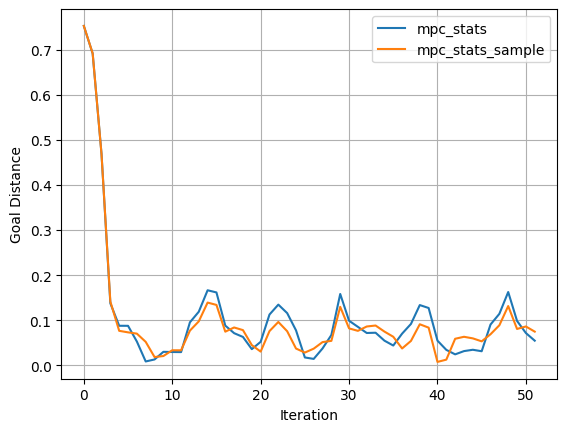

In [9]:
import matplotlib.pyplot as plt

# plot position error of mpc_stats_sample vs mpc_stats on same axis
fig, ax = plt.subplots()
ax.plot(mpc_stats['goal_distances'], label='mpc_stats')
ax.plot(mpc_stats_sample['goal_distances'], label='mpc_stats_sample')
ax.set_xlabel('Iteration')
ax.set_ylabel('Goal Distance')
ax.legend()
ax.grid(True)
plt.show()



In [29]:
for key in mpc_stats:
    print(key)
    print(mpc_stats[key])

solve_times
[0.00351, 0.00351, 0.00352, 0.00293, 0.0029, 0.00271, 0.00309, 0.00302, 0.00333, 0.00298, 0.00333, 0.00341, 0.00322, 0.00336, 0.00307, 0.00293, 0.00304, 0.00291, 0.00288, 0.00305, 0.00299, 0.00341, 0.00303, 0.00283, 0.00282, 0.003, 0.00324, 0.00322, 0.00283, 0.00306, 0.00297, 0.00278, 0.00291, 0.00311, 0.00305, 0.00295, 0.00306, 0.0031, 0.00272, 0.0032, 0.00305, 0.00301, 0.00318, 0.00321, 0.0033, 0.00327, 0.00321, 0.00306, 0.00273, 0.00304, 0.00321, 0.00313, 0.00311, 0.00288, 0.0032, 0.00298, 0.00288, 0.00319, 0.00292, 0.00287, 0.00306, 0.00284, 0.00301, 0.00297, 0.00292, 0.00293, 0.00299, 0.00288]
goal_distances
[1.10206, 1.09005, 1.07876, 1.05902, 1.03848, 1.03439, 1.03054, 1.03753, 1.04306, 0.99094, 0.55312, 0.51594, 0.19267, 0.08356, 0.09976, 0.07582, 0.09612, 0.03272, 0.01942, 0.0134, 0.02019, 0.04337, 0.05525, 0.06068, 0.05631, 0.04501, 0.03905, 0.04463, 0.0598, 0.04083, 0.03982, 0.04098, 0.04498, 0.04544, 0.04459, 0.04399, 0.04021, 0.04094, 0.04595, 0.04691, 0.04781,

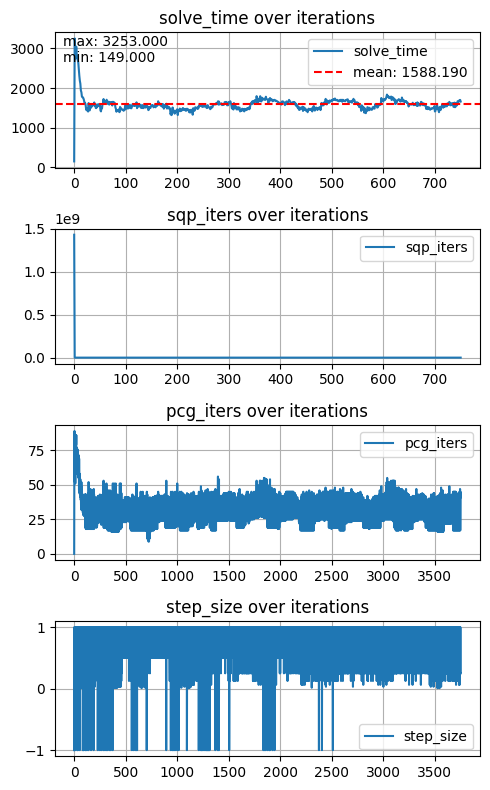

In [142]:
stats = controller.solver.get_stats()

import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(stats), 1, figsize=(5, 2*len(stats)))
if len(stats) == 1:
    axs = [axs]

for i, (key, data) in enumerate(stats.items()):
    ax = axs[i]
    if isinstance(data, dict) and 'values' in data:
        values = data['values']
        ax.plot(values, label=key)
        ax.set_title(f'{key} over iterations')
        if key == 'solve_time':
            ax.axhline(np.mean(values), color='r', linestyle='--', label=f'mean: {np.mean(values):.3f}')
            ax.text(0.02, 0.98, f'max: {np.max(values):.3f}\nmin: {np.min(values):.3f}', 
                   transform=ax.transAxes, verticalalignment='top')
    else:
        ax.plot(data, label=key)
        ax.set_title(f'{key} over iterations')
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()
    

In [194]:
# Load two robot models
model1, visual_model1, collision_model1 = load_robot_model(urdf_path, model_dir)
model2, visual_model2, collision_model2 = load_robot_model(urdf_path, model_dir)

# Setup single visualizer
viz = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz.initViewer(open=True)
viz.loadViewerModel(rootNodeName="robot1", color=[1.0, 0.0, 0.0, 0.5])

viz_2 = MeshcatVisualizer(model1, collision_model1, visual_model1)
viz_2.initViewer(viz.viewer)

# Load second robot model into the same visualizer with a different prefix
viz_2.loadViewerModel(rootNodeName="robot2", color=[0.0, 1.0, 0.0, 0.5])

for i in range(int(len(fig_8_traj)/6)):
    viz.viewer[f'point{i}'].set_object(
        g.Sphere(0.02), 
        g.MeshLambertMaterial(color=0xff0000))
    T = tf.translation_matrix(np.array(fig_8_traj[6*i:6*(i+1)][:3]))
    viz.viewer[f'point{i}'].set_transform(T)
    
q_trajectory1 = q_trajectory
q_trajectory2 = q_trajectory_sample

# Now you can display both trajectories
while True:
    # Display first trajectory on the first robot
    viz.display(q_trajectory1[0])  # Display current state of first trajectory
    
    # Display second trajectory on the second robot
    viz_2.display(q_trajectory2[0])  # Display current state of second trajectory
    
    # Update both trajectories
    q_trajectory1 = q_trajectory1[1:]  # Move to next state
    q_trajectory2 = q_trajectory2[1:]  # Move to next state
    
    time.sleep(0.01)  # Control the display rate

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7010/static/


IndexError: list index out of range

In [ ]:
import pickle

print(q_trajectory)

# save trajectory to file
with open('q_trajectory.pkl', 'wb') as f:
    pickle.dump(q_trajectory, f)